<img style="float: left;" src="https://raw.githubusercontent.com/ProjectPythiaCookbooks/radar-cookbook/main/thumbnail.png" 
width=500>

# Thermodynamic assessment of LASSO-CACTI group

In this jupyter notebook we are going to analyze some thermodynamic variables from multiple ARM datasets, including:
 - Radiosondes
 - Interpolatedsonde
 - LASSO CACTI outputs

 We start by important the python libraries we need

In [1]:
# Libraries required for this tutorial...


import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib.pyplot as plt
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyart

import ipywidgets as ipw
import hvplot.xarray # noqa
import hvplot.pandas # noqa
import panel as pn
import panel.widgets as pnw

import metpy
import metpy.calc as mpcalc
from metpy.units import units
import act

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



### First Let's analyze spatial and temporal variability of CAPE and Rain from LASSO

In [2]:
path = '/data/project/ARM_Summer_School_2024_Data/lasso_tutorial/cacti/lasso-cacti/20190129/eda09/base/les/subset_d3/'
files=glob.glob('/data/project/ARM_Summer_School_2024_Data/lasso_tutorial/cacti/lasso-cacti/20190129/eda09/base/les/subset_d3/corlasso_met_*')

In [3]:
# Reading the dataset from one single file to investigate the shape and properties
ds_wrf = xr.open_dataset(files[0])

# Get location indices for pulling WRF sounding...
xlat = ds_wrf.variables['XLAT'][:, :].values
xlon = ds_wrf.variables['XLONG'][:, :].values

# Pull WRF data for the column above the balloon launch location...
cape = ds_wrf.variables['MUCAPE'][0,:,:].values  
rainfall = ds_wrf.variables['RAINNC'][0,:,:].values  
top = ds_wrf.variables['HGT'][0,:,:].values

In [4]:
# We create a date range to iterate and extract cape values
date_range = pd.date_range('20190129 06:00', '20190129 23:55', freq = '15T')

# Creating empty arrays of CAPE and Rain to store the values at each time step
capes = np.zeros((len(date_range), cape.shape[0], cape.shape[1]))*np.NaN
rains = np.zeros((len(date_range), rainfall.shape[0], rainfall.shape[1]))*np.NaN
times = []

# Let's grab CAPE and rain values for each time step
for i, date in enumerate(date_range[:]):
    file = glob.glob(path + 'corlasso_met_*' + date.strftime('%Y%m%d.%H%M') + '*')
    try:
        ds_wrf = xr.open_dataset(file[0])
        # Pull WRF data for the column above the balloon launch location...
        cape = ds_wrf.variables['MUCAPE'][0,:,:].values 
        rainfall = ds_wrf.variables['RAINNC'][0,:,:].values  
        capes[i, :, :] = cape
        rains[i, :, :] = rainfall
        times.append(date)
    except: 
        continue

In [5]:
# Let's create an xarray for each
capes = xr.DataArray(capes, coords=[times, xlat[:,0], xlon[0,:]], dims=["time", "lat", "lon"])
rains = xr.DataArray(rains, coords=[times, xlat[:,0], xlon[0,:]], dims=["time", "lat", "lon"])

### Creating an animation to see how CAPE and the rainfall evolved

In [6]:
capes.hvplot.quadmesh(x='lon', y='lat', groupby='time',  # sets colormap limits
    widget_type="scrubber", cmap='pyart_HomeyerRainbow', clim = (0,5000),
                              geo=True,
    widget_location="bottom", rasterize=True)

Column
    [0] HoloViews(DynamicMap, sizing_mode='fixed', widget_location='bottom', widget_type='scrubber')
    [1] WidgetBox(align=('center', 'end'))
        [0] Player(end=71, width=550)

In [7]:
rains.hvplot.quadmesh(x='lon', y='lat', groupby='time',  # sets colormap limits
    widget_type="scrubber", cmap='pyart_ChaseSpectral', clim = (0,120),
                              geo=True,
    widget_location="bottom", rasterize=True)

Column
    [0] HoloViews(DynamicMap, sizing_mode='fixed', widget_location='bottom', widget_type='scrubber')
    [1] WidgetBox(align=('center', 'end'))
        [0] Player(end=71, width=550)

### Plot the cumulative rainfall

Text(0.5, 1.0, 'Cumulative Rainfall')

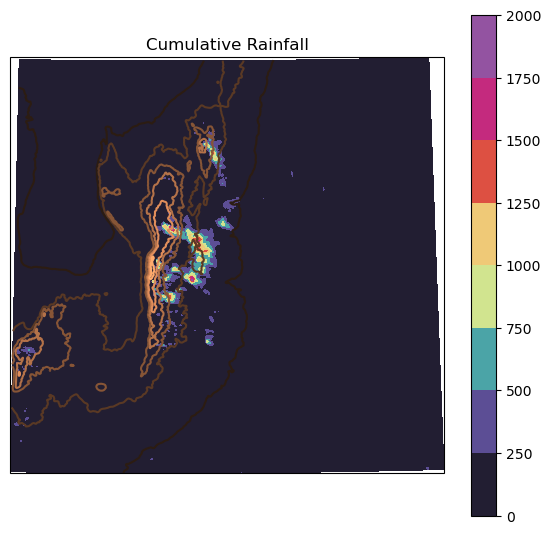

In [8]:
# Make the figure larger
cum_rain = np.nansum(rains, axis = 0)

fig = plt.figure(figsize=(7,6.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree())

# Make a filled contour plot
pcm = ax.contourf(xlon, xlat, cum_rain,
            transform = ccrs.PlateCarree(),
                cmap = 'pyart_ChaseSpectral',
                )
ax.contour(xlon, xlat, top,
            transform = ccrs.PlateCarree(), cmap = 'copper',
               )

fig.colorbar(pcm)# Add coastlines

plt.title('Cumulative Rainfall')

# Observations

##### Now, let's analyze some thermodynamic observations from two ARM products: interpolatedsonde 
##### and radiosondes. In addition, we will compare LASSO outputs with observations
##### we will start by downloading ARM data using ACT

In [9]:
# Set your username and token here!
username = 'YourUser'
token = 'YourToken'

# Set the datastreams 
datastream = 'corinterpolatedsondeM1.c1'

# start/enddates
startdate = '2019-01-29'
enddate = '2019-01-29'

# Use ACT to easily download the data.  Watch for the data citation!  Show some support
# for ARM's instrument experts and cite their data if you use it in a publication
result = act.discovery.download_arm_data(username, token, datastream, startdate, enddate)

[DOWNLOADING] corinterpolatedsondeM1.c1.20190129.000030.nc

If you use these data to prepare a publication, please cite:

Jensen, M., Giangrande, S., Fairless, T., & Zhou, A. Interpolated Sonde
(INTERPOLATEDSONDE). Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1095316



In [10]:
# Let's read in the data using ACT and check out the data
ds_isonde = act.io.read_arm_netcdf(result)

ds_isonde

<xarray.Dataset> Size: 73MB
Dimensions:            (time: 1440, height: 332)
Coordinates:
  * time               (time) datetime64[ns] 12kB 2019-01-29T00:00:30 ... 201...
  * height             (height) float32 1kB 1.141 1.161 1.181 ... 68.0 68.5 69.0
Data variables: (12/39)
    base_time          datetime64[ns] 8B 2019-01-29
    time_offset        (time) datetime64[ns] 12kB 2019-01-29T00:00:30 ... 201...
    precip             (time) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
    qc_precip          (time) int32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
    temp               (time, height) float32 2MB dask.array<chunksize=(1440, 332), meta=np.ndarray>
    qc_temp            (time, height) int32 2MB dask.array<chunksize=(1440, 332), meta=np.ndarray>
    ...                 ...
    qc_rh_scaled       (time, height) int32 2MB dask.array<chunksize=(1440, 332), meta=np.ndarray>
    aqc_rh_scaled      (time, height) int32 2MB dask.array<chunksize=(1440, 332), meta=np.ndarray>
    vapor_source       (time, height) int32 2MB dask.array<chunksize=(1440, 332), meta=np.ndarray>
    lat                float32 4B ...
    lon                float32 4B ...
    alt                float32 4B ...
Attributes: (12/17)
    command_line:          idl -R -n interpolatedsonde -s cor -f M1 -b 201901...
    Conventions:           ARM-1.3
    process_version:       vap-interpolatedsonde-7.1-1.el7
    dod_version:           interpolatedsonde-c1-4.2
    input_datastreams:     corgriddedsondeM1.c0 : 3.2 : 20190127.000030-20190...
    site_id:               cor
    ...                    ...
    doi:                   10.5439/1095316
    history:               created by user zhou on machine prod-proc5.adc.arm...
    _file_dates:           ['20190129']
    _file_times:           ['000030']
    _datastream:           corinterpolatedsondeM1.c1
    _arm_standards_flag:   1

### Let's clean and grab the variables we need

In [11]:
# First, for many of the ACT QC features, we need to get the dataset more to CF standard and that
# involves cleaning up some of the attributes and ways that ARM has historically handled QC
ds_isonde.clean.cleanup()

ds_isonde_troposphere = ds_isonde.sel(height=slice(0,10))

temp = ds_isonde_troposphere.temp
pot_temp = ds_isonde_troposphere.potential_temp
rh = ds_isonde_troposphere.rh
pres = ds_isonde_troposphere.bar_pres

#### The equivalent potential temperature is a good variable to investigate atmospheric stability during cloudy and moist situations, let's compute and plot this variable using interpolatedsonde

In [12]:
# Let's compute the equivalent potential temperature

dewpoint = mpcalc.dewpoint_from_relative_humidity(
            temp,
            rh
        )

te = mpcalc.equivalent_potential_temperature(pres, 
                                            temp, 
                                            dewpoint)

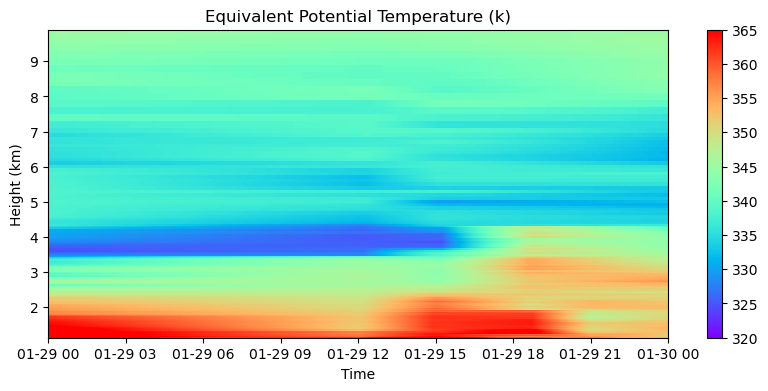

In [13]:
# Here we are making the plot
fig = plt.figure(figsize = (10,4))
ax = fig.add_subplot()
cs = ax.pcolormesh(te.time.data, te.height.data, te.metpy.dequantify().load().T, cmap = 'rainbow', clim=(320, 365))
plt.colorbar(cs)
plt.ylabel('Height (km)')
plt.xlabel('Time')
plt.title('Equivalent Potential Temperature (k)')
plt.savefig('images/te-interpolated.png', dpi = 300)

### Let's compute CAPE using metpy and compare it with LASSO outputs

In [14]:
capes = []
cins = []
for timei in ds_isonde_troposphere.time:
    try:
        data_at_point = ds_isonde_troposphere.metpy.sel(
            time = timei, 
        )
        dewpoint = mpcalc.dewpoint_from_relative_humidity(
            data_at_point['temp'],
            data_at_point['rh']
        )
        cape, cin = mpcalc.surface_based_cape_cin(
            data_at_point['bar_pres'].load(),
            data_at_point['temp'].load(),
            dewpoint.load()
        )
        capes.append(cape.magnitude)
        cins.append(cin.magnitude)
    except ValueError: 
        capes.append(np.NaN)
        cins.append(np.NaN)

In [15]:
# Let's create a function to retrieve LASSO values
def extract_mean_th2(file_path):
        ds = xr.open_dataset(file_path)
        mean_th2 = ds['MUCAPE'].mean().item()
        time = ds['Time'].values[0]
        return time, mean_th2

In [16]:
data_dir = '/data/project/ARM_Summer_School_2024_Data/lasso_tutorial/cacti/lasso-cacti/20190129/eda09/base/les/subset_d3/'
file_pattern = os.path.join(data_dir, 'corlasso_met_*.nc')
nc_files = glob.glob(file_pattern)
# Extract mean TH2 and corresponding time from each file
data = []
for file in nc_files:
    time, mean_th2 = extract_mean_th2(file)
    if time and mean_th2:
        data.append((time, mean_th2))
# Convert the data to a DataFrame and sort by time
df = pd.DataFrame(data, columns=['Time', 'MUCAPE'])
df.sort_values(by='Time', inplace=True)

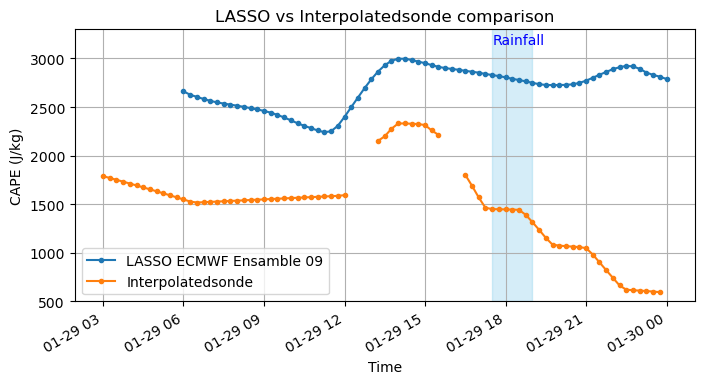

In [17]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(111)
df_cape = pd.DataFrame(capes, ds_isonde_troposphere.time, columns = ['cape'])
df_cape[df_cape==0.] = np.NaN
df_cape['cin'] = cins
ax.plot(df['Time'], df['MUCAPE'], marker='.', linestyle='-', label = 'LASSO ECMWF Ensamble 09')
df_cape['cape'].resample('15T').mean().plot(ax = ax, marker = '.', label = 'Interpolatedsonde')
plt.legend(loc = 3)
plt.xlabel('Time')
plt.ylabel('CAPE (J/kg)')
plt.title('LASSO vs Interpolatedsonde comparison')
plt.grid(True)
plt.ylim(500,3300)
plt.text('2019-01-29 17:30', 3150, 'Rainfall', color = 'blue')
plt.fill_betweenx(y = np.arange(500, 3400, 100), 
                  x1 = '2019-01-29 17:30', 
                  x2 = '2019-01-29 19', 
                  color = 'skyblue', 
                  alpha = 0.35)
plt.show()


### let's take a look at the Equivalent potential Temperature profile

In [18]:
# We need to read the data first
datastream = 'corsondewnpnM1.b1'

# start/enddates
startdate = '2019-01-29'
enddate = '2019-01-29'

# Use ACT to easily download the data.  Watch for the data citation!  Show some support
# for ARM's instrument experts and cite their data if you use it in a publication
result = act.discovery.download_arm_data(username, token, datastream, startdate, enddate)

[DOWNLOADING] corsondewnpnM1.b1.20190129.120000.cdf
[DOWNLOADING] corsondewnpnM1.b1.20190129.210300.cdf
[DOWNLOADING] corsondewnpnM1.b1.20190129.000000.cdf
[DOWNLOADING] corsondewnpnM1.b1.20190129.183500.cdf
[DOWNLOADING] corsondewnpnM1.b1.20190129.150000.cdf

If you use these data to prepare a publication, please cite:

Keeler, E., Burk, K., & Kyrouac, J. Balloon-Borne Sounding System (SONDEWNPN).
Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1595321



In [19]:
#Since we have multiple radiosonde files for one single day, we will iterate to read them all
ds_s = []
for file in result:
    ds = act.io.read_arm_netcdf(file)
    ds_s.append(ds)

# Concatenating the files into one single xarray
ds_final = xr.concat(ds_s, dim='sounding')

In [20]:
# Let's compute the equivalent potential temperature with metpy

dewpoint = mpcalc.dewpoint_from_relative_humidity(
            ds_final.tdry,
            ds_final.rh
        )

te = mpcalc.equivalent_potential_temperature(ds_final.pres, 
                                            ds_final.tdry, 
                                            dewpoint)

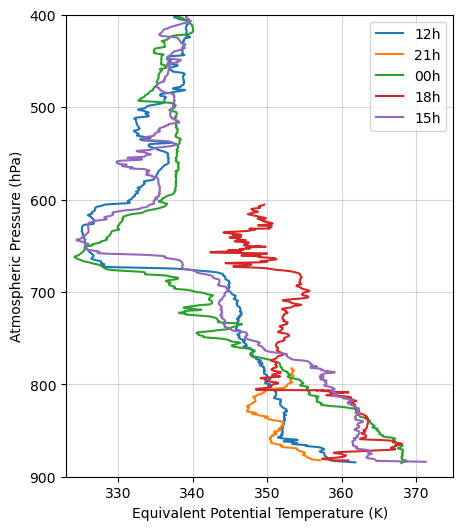

In [21]:
# Finally, let's make a plot

fig = plt.figure(figsize=(5,6))
times = ['12h','21h','00h','18h','15h']
for i in range(0,5,1):
    plt.plot(te.sel(sounding=i)[::-1], ds_final.sel(sounding = i).pres[::-1], label = times[i])
plt.ylim(900,400)
plt.xlim(323, 375)
plt.legend()
plt.grid(':', alpha = 0.5)
plt.ylabel('Atmospheric Pressure (hPa)')
plt.xlabel('Equivalent Potential Temperature (K)')
plt.show()

# Finally, let's take a look at the moisture observations

[DOWNLOADING] cormwrlosM1.b1.20190129.000001.cdf

If you use these data to prepare a publication, please cite:

Cadeddu, M., & Tuftedal, M. Microwave Radiometer (MWRLOS). Atmospheric Radiation
Measurement (ARM) User Facility. https://doi.org/10.5439/1999490

[DOWNLOADING] corldM1.b1.20190129.000000.cdf

If you use these data to prepare a publication, please cite:

Wang, D., Bartholomew, M. J., Zhu, Z., & Shi, Y. Laser Disdrometer (LD).
Atmospheric Radiation Measurement (ARM) User Facility.
https://doi.org/10.5439/1973058



Text(0.5, 1.0, 'VAPOR')

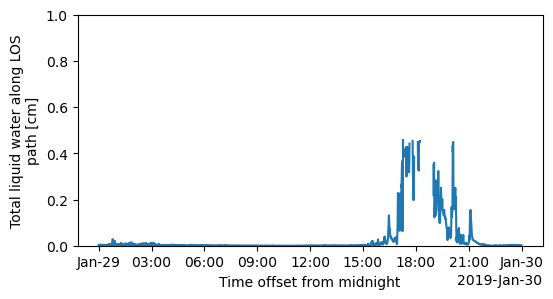

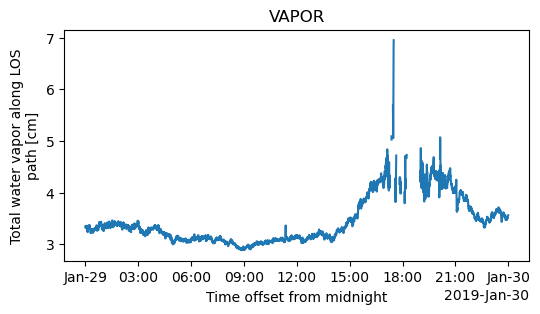

In [24]:
# Set the datastream and start/enddates
datastream = 'cormwrlosM1.b1'      #MWR
datastream_disdro ='corldM1.b1'    #DISDRO
startdate = '2019-01-29'
enddate = '2019-01-29'

result1 = act.discovery.download_arm_data(username, token, datastream, startdate, enddate)
result2 = act.discovery.download_arm_data(username, token, datastream_disdro, startdate, enddate)

ds=xr.open_dataset("cormwrlosM1.b1/cormwrlosM1.b1.20190129.000001.cdf")
qc_liq=ds.qc_liq
qc_liq=qc_liq.where(qc_liq>0)
fig = plt.figure(figsize=(6, 3))
plt.ylim(0,1)
plt.title("Liquid water content")
#plt.show()
plt.savefig("LWC.png")
#plt.title("LWC")
ds.liq.plot()
fig = plt.figure(figsize=(6, 3))
ds.vap.plot()
plt.title("VAPOR")
#plt.savefig("VP.png")

In [23]:
pwd

'/data/home/natalia/cacti-deep-convection/notebooks'